<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/CNN_simple_YouTube_clickbait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 679 kB 5.2 MB/s 


In [ ]:
#! pip install tensorflow --upgrade

     |████████████████████████████████| 458.3 MB 10 kB/s 
     |████████████████████████████████| 5.6 MB 39.4 MB/s 
     |████████████████████████████████| 462 kB 49.7 MB/s 
     |████████████████████████████████| 4.3 MB 13.8 MB/s 
     |████████████████████████████████| 1.3 MB 35.4 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=82edceee3fa59b9dad72d8a426dec9dd21ce4c8de61eafa1598dcdcc74a7751c
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
Successfully built clang
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: 

#Imports

In [2]:
import os, sys, math
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa   # for optimizer
import keras.backend as K
import tensorflow_hub as hub
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#Configurations

In [20]:
TARGET_SIZE = [180, 180]
CLASSES = ['nonclickbaits', 'clickbaits'] 
NUM_CLASSES = 2
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
WIDTH = 180
HEIGHT = 180
CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, CHANNELS)


label_list = [0,1]
init_lr = 1e-4
epochs=1

In [5]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
fvc_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models'
saved_model_name = f'youtube_clickbait_simple_CNN'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_simple_CNN'
if not os.path.exists(checkpoint_root_path):
    os.makedirs(checkpoint_root_path)
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_simple_CNN_checkpoint' )

#Scripts

In [6]:
def read_tfrecord(example): 
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    label  = example['label']
    return image, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  dataset = dataset.map(lambda image, class_num, label: (image, class_num))
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [7]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

#Read TFRecord data

In [8]:

read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=0)

read_fvc_clickbait_data = read_tfrec_data(fvc_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=0)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

fvc_filenames, fvc_training_filenames, fvc_validation_filenames, fvc_testing_filenames = read_fvc_clickbait_data.get_tfrec_files()


filenames = YouTube_filenames + fvc_filenames
training_filenames = YouTube_training_filenames + fvc_training_filenames
validation_filenames = YouTube_validation_filenames + fvc_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

print(f'Length FileNames : {len(filenames)} Length Training FileNames : {len(training_filenames)} Length Validation FileNames : {len(validation_filenames)}')

num_train_examples = 974 * len(YouTube_training_filenames) + 100 * len(fvc_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 100 * len(fvc_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE


print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 16 data files. Splitting dataset into 13 training files , 3 validation files and 0 test files
Length FileNames : 30 Length Training FileNames : 25 Length Validation FileNames : 5
With a batch size of 32, there will be 396 batches per training epoch and 79 batch(es) per validation run.


In [9]:
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=0) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=0) # Used only for benchmarking


testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

len(testing_filenames), len(benchmarking_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


(2, 4)

In [10]:
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

#Load TFRecord into TF Dataset

In [11]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)
  benchmark_ds = load_dataset(benchmarking_filenames)

In [12]:
with tf.device('/cpu:0'):
  train_ds = get_batched_dataset(train_ds, train=True)
  val_ds = get_batched_dataset(val_ds)
  test_ds = get_batched_dataset(test_ds)
  benchmark_ds = get_batched_dataset(benchmark_ds)

In [13]:
for image, class_num in train_ds.take(1):
  for i in range(32):
    print(f"Image shape {image[i].shape}, Class={class_num[i]}, Label={CLASSES[class_num[i]]}")

Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=1, Label=clickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180, 180, 3), Class=0, Label=nonclickbaits
Image shape (180

In [14]:
train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, benchmark_ds.element_spec

((TensorSpec(shape=(32, 180, 180, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(32, 180, 180, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(32, 180, 180, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(32, 180, 180, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32,), dtype=tf.int64, name=None)))

#Modeling

##Build classifier

In [21]:
classifier_model = create_model(INPUT_SHAPE, NUM_CLASSES)
classifier_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 128)       73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 90, 128)       512 

#Train classifier model

##Compile model

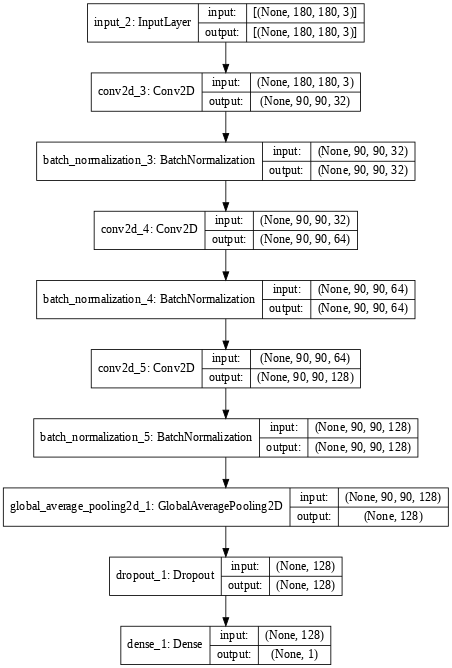

In [22]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

#optimizer = optimization.create_optimizer(
#      init_lr=init_lr,
#      num_train_steps=num_train_steps,
#      num_warmup_steps=num_warmup_steps,
#      optimizer_type='adamw'
#      )

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=num_train_steps,
    decay_rate=0.90,
    staircase=False)

optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

##Train

In [23]:
if os.path.exists(checkpoint_root_path) & len(os.listdir(checkpoint_root_path))>0:
  print('loading saved weight')
  classifier_model.load_weights(model_checkpoint_path)
else:
  print('No weight to initialize')

loading saved weight


In [24]:
history = classifier_model.fit(
             x=train_ds,
             validation_data=val_ds,
             epochs=epochs,
             callbacks=[es, mcb]
             )

405/405 [==============================] - 1653s 4s/step - loss: 0.6631 - tp: 3322.0000 - fp: 2389.0000 - tn: 4422.0000 - fn: 2827.0000 - accuracy: 0.5975 - precision: 0.5817 - recall: 0.5403 - auc: 0.6402 - prc: 0.5882 - val_loss: 0.6599 - val_tp: 638.0000 - val_fp: 451.0000 - val_tn: 752.0000 - val_fn: 399.0000 - val_accuracy: 0.6205 - val_precision: 0.5859 - val_recall: 0.6152 - val_auc: 0.6602 - val_prc: 0.5936

Epoch 00001: val_loss improved from inf to 0.65994, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_simple_CNN/youtube_clickbait_simple_CNN_checkpoint


#Plot train history

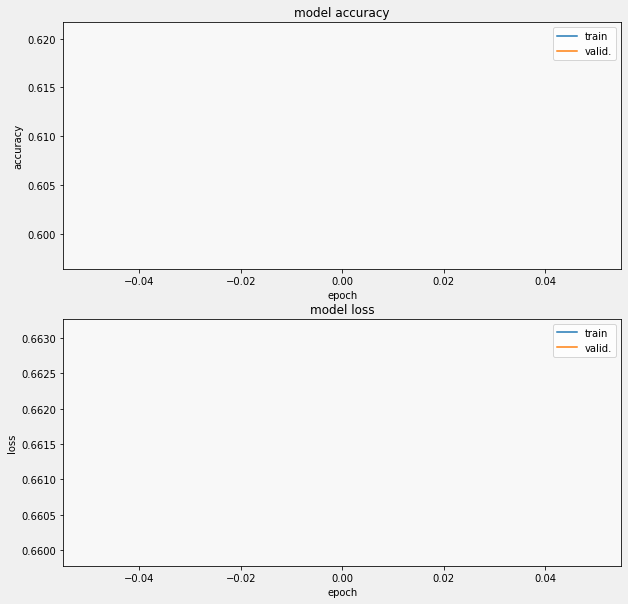

In [25]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)


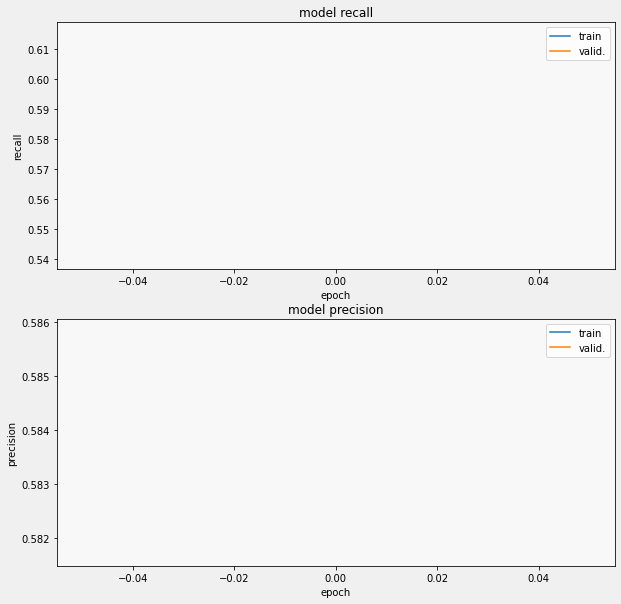

In [26]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Model Inference

##Evaluate Classifier on Test set

In [27]:
results_test_set = classifier_model.evaluate(test_ds)

for name, value in zip(classifier_model.metrics_names, results_test_set):
  print(name, ': ', value)
print()

60/60 [==============================] - 66s 1s/step - loss: 0.6650 - tp: 561.0000 - fp: 404.0000 - tn: 618.0000 - fn: 337.0000 - accuracy: 0.6141 - precision: 0.5813 - recall: 0.6247 - auc: 0.6497 - prc: 0.5692
loss :  0.6650246381759644
tp :  561.0
fp :  404.0
tn :  618.0
fn :  337.0
accuracy :  0.614062488079071
precision :  0.5813471674919128
recall :  0.6247215867042542
auc :  0.6497151255607605
prc :  0.569202721118927



In [ ]:
test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(classifier_model,test_ds, BATCH_SIZE=BATCH_SIZE, N=30)

In [ ]:
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

##Evaluate Classifier on Benchmarking set

In [ ]:
results_benchmarking_set = classifier_model.evaluate(benchmark_ds)

for name, value in zip(classifier_model.metrics_names, results_benchmarking_set):
  print(name, ': ', value)
print()

In [ ]:
benchmark_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(classifier_model,benchmark_ds, BATCH_SIZE=BATCH_SIZE, N=30)

In [ ]:
vh.display_9_images_with_predictions(benchmark_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)